In [1]:
import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
class DataGenerator:
    def __init__(
        self,
        choice_probability: list[float] = [0.75, 0.2, 0.05],
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.choice_probability = choice_probability
        self.total_panel = total_panel
        self.choices = np.fromiter(range(len(choice_probability)), dtype=int)
        self.is_treatment_group = not control_group
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        full_panel_data = np.random.choice(a = self.choices, size = (n_samples, self.total_panel), p = self.choice_probability)
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data
    
    def get_mean(self):
        return np.array(self.choice_probability) @ self.choices

In [3]:

def surrogate_index_model_experiment(
        n_surrogate_list:list = [4],
        sample_size = 1000,
        control_probabilities = [0.75, 0.2, 0.05],
        treatment_probabilities = [0.74, 0.205, 0.055]
    ) -> tuple[float, list[float]]:
    control_data = (
        DataGenerator(
            choice_probability = control_probabilities,
            control_group=True
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )
    treatment_data = (
        DataGenerator(
            choice_probability = treatment_probabilities,
            control_group=False
        )
        .generate_data(
            n_surrogates=max(n_surrogate_list),
            n_samples=sample_size
        )
    )

    experiment_data = pd.concat([control_data, treatment_data])

    train_data, test_data = train_test_split(experiment_data, test_size=0.5)

    observed_experiment_analysis = (
        smf.ols(
            formula = 'unit_total ~ 1 + treatment',
            data = test_data
        )
        .fit()
    )
    observed_experiment_treatment_effect = observed_experiment_analysis.params['treatment']

    predicted_experiment_treatment_effects = list()

    for n_surrogates in n_surrogate_list:


        surrogate_index_model = (
            smf.ols(
                formula = 'unit_total ~ 1 + ' + ' + '.join([f'surrogate_{i}' for i in range(n_surrogates)]),
                data = train_data
            )
            .fit()
        )
        predicted_test_data = (
            test_data
            .assign(
                predicted_unit_total = surrogate_index_model.predict(test_data)
            )
        )

        predicted_experiment_analysis = (
            smf.ols(
                formula = 'predicted_unit_total ~ 1 + treatment',
                data = predicted_test_data
            )
            .fit()
        )
        predicted_experiment_treatment_effect = predicted_experiment_analysis.params['treatment']
        predicted_experiment_treatment_effects.append(predicted_experiment_treatment_effect)



    return observed_experiment_treatment_effect, predicted_experiment_treatment_effects


In [4]:
observed_effects = list()
predicted_effects = list()
n_surrogate_list = [4, 8, 32, 51]
for i in range(100):
    observed_effect, predicted_effect = surrogate_index_model_experiment(n_surrogate_list=n_surrogate_list)
    observed_effects.append(observed_effect)
    predicted_effects.append(predicted_effect)
predicted_effects = pd.DataFrame(
    data = np.array(predicted_effects),
    columns = n_surrogate_list
)

Text(0.5, 0, 'Treatment Effect')

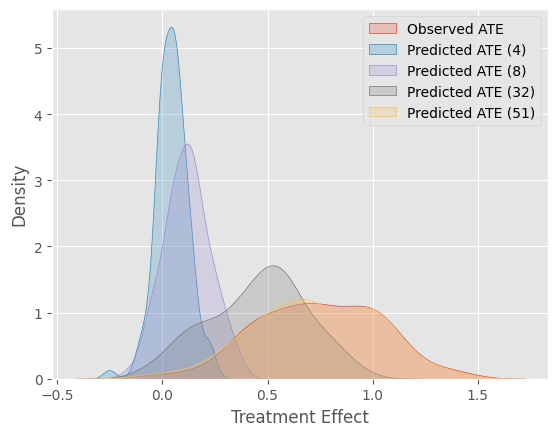

In [5]:
fig, ax = plt.subplots()
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
for n_surrogates in n_surrogate_list:
    sns.kdeplot(predicted_effects.loc[:, n_surrogates], label=f'Predicted ATE ({n_surrogates})', ax = ax, fill = True)

ax.legend()
ax.set_xlabel('Treatment Effect')